# Platform Data Analysis

## Execution

### Import packages

In [6]:
# pip3 install mariadb
# pip3 install pandas
# pip3 install numpy  
# sudo apt-get install libatlas-base-dev
# pip3 install matplotlib

# pip3 install ipympl
# pip3 install ipywidgets

%matplotlib widget
%config InlineBackend.figure_format = 'png'

import os
import numpy as np
import pandas as pd

from IPython.display import Markdown


from ipywidgets import interact, interactive, interactive_output, fixed, interact_manual, IntSlider, IntRangeSlider, HBox
import requests
import random
import ipywidgets as widgets

### Data Visualization 

In [7]:
from utility import db_conn, plot
import config

username = os.environ.get("db_user")
password = os.environ.get("db_pwd")

db_name_button = widgets.RadioButtons(
        options=['Reformer_BW', 'Reformer_SE'],
        description='Select Database:',
        disabled=False
        )

config.db_name = db_name_button.value
config.cur = db_conn(username=username, password=password, db_name=config.db_name)
config.cur.execute('SHOW tables')

table_dropdown = widgets.Dropdown(options=[u for i in config.cur.fetchall()[:] for u in i][::-1], description='Table')

config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
config.cur.fetchall()

time_slider = widgets.IntRangeSlider(value=[0, config.cur.rowcount], max=config.cur.rowcount, step=1200, description='Time Span', continuous_update=False)
checkbox = widgets.Checkbox(value=False, description='Steady-State Only', disabled=False, indent=False)
toggle_calc = widgets.ToggleButton(value=False, description='Only Calc', disabled=False, button_style='success', tooltip='Description',icon='check')
toggle_plot = widgets.ToggleButton(value=False, description='Plot it!', disabled=False, button_style='info', tooltip='Description',icon='check')


alter_db = False
def update_db_name(change):
    global alter_db
    alter_db = True
    config.db_name = change.new
    config.cur = db_conn(username=username, password=password, db_name=config.db_name)
    config.cur.execute('SHOW tables')
    table_dropdown.options = [u for i in config.cur.fetchall()[:] for u in i][::-1]
    config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
    config.cur.fetchall()
    columns_button.options = [col[0] for col in config.cur.description]
    time_slider.max = config.cur.rowcount
    time_slider.value = [0, time_slider.max]
db_name_button.observe(update_db_name, 'value')    


def update_range(*args):
    global alter_db
    if not alter_db:
        config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
        config.cur.fetchall()
        time_slider.max = config.cur.rowcount
        time_slider.value = [0, time_slider.max]
        columns_button.options = [col[0] for col in config.cur.description]
        print('change time', time_slider.value)
        print('change time', time_slider.max)
        #TC_selector.options = [i[0] for i in cur.description if re.search("^TC|^EVA", i[0])]
    else:
        alter_db = False
table_dropdown.observe(update_range, 'value')


plot = interactive_output(plot, {'Table_name':table_dropdown, 'Time':time_slider, 'SS':checkbox, 'Calc': toggle_calc, 'Ploting':toggle_plot})

toggle = HBox([toggle_calc, toggle_plot])
control = HBox([table_dropdown, time_slider, checkbox,])
#selector = HBox([TC_selector])
widgets.VBox([db_name_button, toggle, control, plot])


In [8]:
#BlueWorld steady_state = ['20%','40%','60%','80%','100%']
#Serenergy steady_state = ['18A','34A','51A','68A','85A']

for i in range(len(config.Steady_State_lst)):
    
    if config.db_name == 'Reformer_BW':
        print(f"穩定時參數 {config.Steady_State_lst[i]} :")
            # [Abstract] Temperature 
        reference_temperature = 0
        if config.Steady_State_lst[i] == '20%'    : reference_temperature = 270   
        elif  config.Steady_State_lst[i] == '40%' : reference_temperature = 280 
        elif  config.Steady_State_lst[i] == '60%' : reference_temperature = 260
        elif  config.Steady_State_lst[i] == '80%' : reference_temperature = 260
        else : reference_temperature = 260
    # [air lpm sv]
#         if config.Steady_State_lst[i] == '20%': print(f'MFC空氣流量設定值:{config.avg_Pump_SET_SV_lst[i]} [LPM]')
#         elif  config.Steady_State_lst[i] == '40%' : print(f'MFC空氣流量設定值:{config.avg_Pump_SET_SV_lst[i]} [LPM]')
#         elif  config.Steady_State_lst[i] == '60%' : print(f'MFC空氣流量設定值:{config.avg_Pump_SET_SV_lst[i]} [LPM]')
#         elif  config.Steady_State_lst[i] == '80%' : print(f'MFC空氣流量設定值:{config.avg_Pump_SET_SV_lst[i]} [LPM]')
#         else : print(f'MFC空氣流量設定值:{config.avg_Pump_SET_SV_lst[i]} ')   
    # [MEOH  sv]
#         if config.Steady_State_lst[i] == '20%': print(f'甲醇設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [g]')
#         elif  config.Steady_State_lst[i] == '40%' : print(f'甲醇設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [g]')
#         elif  config.Steady_State_lst[i] == '60%' : print(f'甲醇設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [g]')
#         elif  config.Steady_State_lst[i] == '80%' : print(f'甲醇設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [g]')
#         else : print(f'甲醇設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [g]')   
    # [tc temperature]
        print(f'觸媒床頭段平均溫度(TC8): {config.avg_TC8_lst[i]}oC, 參考溫度:{reference_temperature} oC,溫度差值:{round(reference_temperature - config.avg_TC8_lst[i],2)}  ')
        # Temperature Warning : +-5 oC
        if( config.avg_TC8_lst[i] > reference_temperature+5 or config.avg_TC8_lst[i] < reference_temperature-5 ) : display(Markdown(' <span style="color: #ff0000"> 請確認觸媒床溫度(TC8)警告!!</span>'))   
    # [eva temperture]
        print(f"汽化室出口溫度: {config.avg_EVA_Out_lst[i]}, 參考溫度:200 ~ 220 oC") 
        if config.avg_EVA_Out_lst[i] >= 220: print(f'汽化室出口溫差: {round(config.avg_EVA_Out_lst[i]- 220,2) } oC')
        elif config.avg_EVA_Out_lst[i] <=200: print(f'汽化室出口溫差: {round(200 - config.avg_EVA_Out_lst[i],2) } oC') 
        if( config.avg_EVA_Out_lst[i] >= 220 or config.avg_EVA_Out_lst[i] <= 200 ) : display(Markdown(' <span style="color:#ff0000">請確認汽化室出口溫度!!</span>'))   
    
    # [meoh-water flow]
        if config.Steady_State_lst[i] == '20%': print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 24.08 [g/min] ,甲醇水進料量差值:{ round(config.avg_Scale_lst[i] - 24.08,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '40%' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 48.16 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 48.16,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '60%' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 72.23 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 72.23,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '80%' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 96.31 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 96.31,2) } [g/min]')
        else : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min]", 理論進料量 : 120.39 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 120.39,2) } [g/min]')       
    # [time]
        print(f"穩定時間區間:{config.initial_time_lst[i]}-{config.end_time_lst[i]} [sec]  約為({(config.end_time_lst[i] - config.initial_time_lst[i])/60} min)")
    # [richgas products]
        if config.Steady_State_lst[i] == '20%': print(f'平均總氣體產出量:{config.avg_DFM_RichGas_lst[i]} ')
        elif  config.Steady_State_lst[i] == '40%' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_lst[i]} ')
        elif  config.Steady_State_lst[i] == '60%' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_lst[i]} ')
        elif  config.Steady_State_lst[i] == '80%' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_lst[i]}')
        else : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_lst[i]} [LPM]')    
    # [h2 products]
        if config.Steady_State_lst[i] == '20%': print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        elif  config.Steady_State_lst[i] == '40%' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        elif  config.Steady_State_lst[i] == '60%' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM] ')
        elif  config.Steady_State_lst[i] == '80%' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        else : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM]",理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 :{round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)}  [LPM]')   

        print(f"反應轉化效率: {config.con_rate_lst[i]} %")
        print(f"H2百分比(%): {config.avg_GA_H2_lst[i]} %")
        if( config.avg_GA_H2_lst[i] <= 70 ) : display(Markdown('<span style="color:#ff0000">請確認是否異常!!</span>'))   

        print(f"CO2百分比(%): {config.avg_GA_CO2_lst[i]} %")
        print(f"CO百分比(%): {config.avg_GA_CO_lst[i]} %")
        if( config.avg_GA_CO_lst[i] >= 1 ) : display(Markdown('<span style="color:#ff0000">請確認是否異常!!</span>'))   
        print('-----------------------------------------------------------------------------------------------------------')
    elif config.db_name == 'Reformer_SE':
        print(f"穩定時參數 {config.Steady_State_lst[i]} :")
    
    
        # [Abstract] Temperature 
        reference_temperature = 0
        if config.Steady_State_lst[i] == '18A'    : reference_temperature = 300   
        elif  config.Steady_State_lst[i] == '34A' : reference_temperature = 305 
        elif  config.Steady_State_lst[i] == '51A' : reference_temperature = 315
        elif  config.Steady_State_lst[i] == '68A' : reference_temperature = 325
        else : reference_temperature = 332

        if config.Steady_State_lst[i] == '18A': print(f'MFC空氣流量設定值:{config.avg_Air_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '34A' : print(f'MFC空氣流量設定值:{config.avg_Air_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '51A' : print(f'MFC空氣流量設定值:{config.avg_Air_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '68A' : print(f'MFC空氣流量設定值:{config.avg_Air_MFC_SET_SV_lst[i]} [LPM]')
        else : print(f'MFC空氣流量設定值:{config.avg_Air_MFC_SET_SV_lst[i]} [LPM]')   

        if config.Steady_State_lst[i] == '18A': print(f'MFC氫氣流量設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '34A' : print(f'MFC氫氣流量設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '51A' : print(f'MFC氫氣流量設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [LPM]')
        elif  config.Steady_State_lst[i] == '68A' : print(f'MFC氫氣流量設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [LPM]')
        else : print(f'MFC氫氣流量設定值:{config.avg_H2_MFC_SET_SV_lst[i]} [LPM]')   

        print(f'觸媒床平均溫度(TC10): {config.avg_TC10_lst[i]}oC, 參考溫度:{reference_temperature} oC,溫度差值:{round(reference_temperature - config.avg_TC10_lst[i],2)}  ')
        # Temperature Warning : +-5 oC
        if( config.avg_TC10_lst[i] > reference_temperature+5 or config.avg_TC10_lst[i] < reference_temperature-5 ) : display(Markdown(' <span style="color: #ff0000"> 請確認觸媒床溫度(TC10)警告!!</span>'))   

        print(f"汽化室出口溫度: {config.avg_Exhaust_gas_lst[i]}, 參考溫度:200 ~ 220 oC") 
        if config.avg_Exhaust_gas_lst[i] >= 220: print(f'汽化室出口溫差: {round(config.avg_Exhaust_gas_lst[i]- 220,2) } oC')
        elif config.avg_Exhaust_gas_lst[i] <=200: print(f'汽化室出口溫差: {round(200 - config.avg_Exhaust_gas_lst[i],2) } oC') 
        if( config.avg_Exhaust_gas_lst[i] >= 220 or config.avg_Exhaust_gas_lst[i] <= 200 ) : display(Markdown(' <span style="color:#ff0000">請確認汽化室出口溫度!!</span>'))   


        if config.Steady_State_lst[i] == '18A': print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 18.91 [g/min] ,甲醇水進料量差值:{ round(config.avg_Scale_lst[i] - 18.91,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '34A' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 31.85 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 31.85,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '51A' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 49.02 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 49.02,2) } [g/min]')
        elif  config.Steady_State_lst[i] == '68A' : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min], 理論進料量 : 63.10 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 63.10,2) } [g/min]')
        else : print(f'甲醇水進料量:{config.avg_Scale_lst[i]} [g/min]", 理論進料量 : 81.45 [g/min] ,甲醇水進料量差值:{round(config.avg_Scale_lst[i] - 81.45,2) } [g/min]')       

        print(f"穩定時間區間:{config.initial_time_lst[i]}-{config.end_time_lst[i]} [sec]  約為({(config.end_time_lst[i] - config.initial_time_lst[i])/60} min)")

        if config.Steady_State_lst[i] == '18A': print(f'平均總氣體產出量:{config.avg_DFM_RichGas_1min_lst[i]} ')
        elif  config.Steady_State_lst[i] == '34A' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_1min_lst[i]} ')
        elif  config.Steady_State_lst[i] == '51A' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_1min_lst[i]} ')
        elif  config.Steady_State_lst[i] == '68A' : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_1min_lst[i]}')
        else : print(f'平均總氣體產出量:{config.avg_DFM_RichGas_1min_lst[i]} [LPM]')    

        if config.Steady_State_lst[i] == '18A': print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        elif  config.Steady_State_lst[i] == '34A' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        elif  config.Steady_State_lst[i] == '51A' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM] ')
        elif  config.Steady_State_lst[i] == '68A' : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM], 理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 : {round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)} [LPM]')
        else : print(f'平均氫氣產出量:{config.avg_H2_flow_lst[i]} [LPM]",理論產氫量 :{config.ideal_H2_flow_lst[i] }  [LPM] ,產氫量差值 :{round(config.ideal_H2_flow_lst[i] - config.avg_H2_flow_lst[i],2)}  [LPM]')   

        print(f"反應轉化效率: {config.con_rate_lst[i]} %")
        print(f"H2百分比(%): {config.avg_GA_H2_lst[i]} %")
        if( config.avg_GA_H2_lst[i] <= 70 ) : display(Markdown('<span style="color:#ff0000">請確認是否異常!!</span>'))   

        print(f"CO2百分比(%): {config.avg_GA_CO2_lst[i]} %")
        print(f"CO百分比(%): {config.avg_GA_CO_lst[i]} %")
        if( config.avg_GA_CO_lst[i] >= 1 ) : display(Markdown('<span style="color:#ff0000">請確認是否異常!!</span>'))   
        print('-----------------------------------------------------------------------------------------------------------')
    pass

穩定時參數 18A :
MFC空氣流量設定值:80.0 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 301.38oC, 參考溫度:300 oC,溫度差值:-1.38  
汽化室出口溫度: 177.43, 參考溫度:200 ~ 220 oC
汽化室出口溫差: 22.57 oC


 <span style="color:#ff0000">請確認汽化室出口溫度!!</span>

甲醇水進料量:19.68 [g/min], 理論進料量 : 18.91 [g/min] ,甲醇水進料量差值:0.77 [g/min]
穩定時間區間:2820-3300 [sec]  約為(8.0 min)
平均總氣體產出量:23.76 
平均氫氣產出量:23.58 [LPM], 理論產氫量 :23.41  [LPM] ,產氫量差值 : -0.17 [LPM]
反應轉化效率: 100.69 %
H2百分比(%): 71.01 %
CO2百分比(%): 25.68 %
CO百分比(%): 0.44 %
-----------------------------------------------------------------------------------------------------------
穩定時參數 51A :
MFC空氣流量設定值:100.0 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 314.01oC, 參考溫度:315 oC,溫度差值:0.99  
汽化室出口溫度: 201.12, 參考溫度:200 ~ 220 oC
甲醇水進料量:44.98 [g/min], 理論進料量 : 49.02 [g/min] ,甲醇水進料量差值:-4.04 [g/min]
穩定時間區間:3840-4200 [sec]  約為(6.0 min)
平均總氣體產出量:62.7 
平均氫氣產出量:54.39 [LPM], 理論產氫量 :53.98  [LPM] ,產氫量差值 : -0.41 [LPM] 
反應轉化效率: 100.77 %
H2百分比(%): 71.1 %
CO2百分比(%): 25.32 %
CO百分比(%): 0.6 %
-----------------------------------------------------------------------------------------------------------
穩定時參數 34A :
MFC空氣流量設定值:90.0 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 303.56oC, 參考溫度:305 oC,溫度差值:1.44  
汽化室出口溫度: 202.92, 參考溫度:200 ~ 220 oC
甲醇

 <span style="color:#ff0000">請確認汽化室出口溫度!!</span>

甲醇水進料量:62.2 [g/min], 理論進料量 : 63.10 [g/min] ,甲醇水進料量差值:-0.9 [g/min]
穩定時間區間:6900-7200 [sec]  約為(5.0 min)
平均總氣體產出量:86.76
平均氫氣產出量:73.16 [LPM], 理論產氫量 :73.82  [LPM] ,產氫量差值 : 0.66 [LPM]
反應轉化效率: 99.11 %
H2百分比(%): 71.2 %
CO2百分比(%): 25.21 %
CO百分比(%): 0.43 %
-----------------------------------------------------------------------------------------------------------
穩定時參數 18A :
MFC空氣流量設定值:80.08 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 302.72oC, 參考溫度:300 oC,溫度差值:-2.72  
汽化室出口溫度: 198.73, 參考溫度:200 ~ 220 oC
汽化室出口溫差: 1.27 oC


 <span style="color:#ff0000">請確認汽化室出口溫度!!</span>

甲醇水進料量:19.39 [g/min], 理論進料量 : 18.91 [g/min] ,甲醇水進料量差值:0.48 [g/min]
穩定時間區間:7740-8160 [sec]  約為(7.0 min)
平均總氣體產出量:24.91 
平均氫氣產出量:23.89 [LPM], 理論產氫量 :23.17  [LPM] ,產氫量差值 : -0.72 [LPM]
反應轉化效率: 103.09 %
H2百分比(%): 71.78 %
CO2百分比(%): 25.24 %
CO百分比(%): 0.7 %
-----------------------------------------------------------------------------------------------------------
穩定時參數 85A :
MFC空氣流量設定值:130.0 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 327.69oC, 參考溫度:332 oC,溫度差值:4.31  
汽化室出口溫度: 212.64, 參考溫度:200 ~ 220 oC
甲醇水進料量:77.65 [g/min]", 理論進料量 : 81.45 [g/min] ,甲醇水進料量差值:-3.8 [g/min]
穩定時間區間:8760-9000 [sec]  約為(4.0 min)
平均總氣體產出量:110.26 [LPM]
平均氫氣產出量:92.72 [LPM]",理論產氫量 :92.97  [LPM] ,產氫量差值 :0.25  [LPM]
反應轉化效率: 99.73 %
H2百分比(%): 72.4 %
CO2百分比(%): 25.58 %
CO百分比(%): 0.46 %
-----------------------------------------------------------------------------------------------------------
穩定時參數 18A :
MFC空氣流量設定值:80.0 [LPM]
MFC氫氣流量設定值:0.0 [LPM]
觸媒床平均溫度(TC10): 302.08oC, 參考溫度:300 oC,溫度差值:-2.08  
汽化室出口溫度: 206.77, 參考溫度:200 ~ 220 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
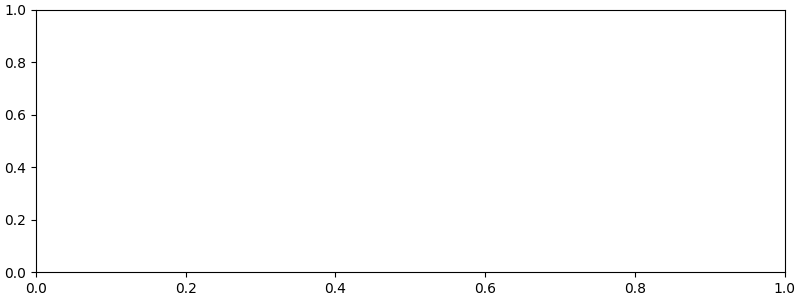

In [4]:
from utility import plot_cols
import matplotlib.pyplot as plt

fig_col, ax_col = plt.subplots(1, constrained_layout=True, figsize=(8,3), sharex=False)
fig_col.canvas.toolbar_position = 'left'
    
config.cur.execute(f"SELECT * FROM {table_dropdown.value}")
columns_button = widgets.SelectMultiple(options=[col[0] for col in config.cur.description], description='Select Cols', disabled=False, continuous_update=False)

# print('-----------------------------------------------------------------------------------------------------------')
# def multi_checkbox_widget(options_dict):
#     options_dict = { x: widgets.Checkbox( description=x,  value=False,style={"description_width":"0px"}  ) for x in ['hello','world']}


# print('-----------------------------------------------------------------------------------------------------------')
def update_col_names(change) -> str:
    string = ""
    for i in change.new:
        string = string + i + ','
    plot_cols(col_string=string[:-1], table_name=table_dropdown.value, ax=ax_col)
columns_button.observe(update_col_names, 'value')
widgets.Checkbox(
    value=False,
    description='Check me',
    disabled=False,
    indent=False
)
# def f(**args):  results = [key for key, value in args.items() if value]
# display(results)

# ui = multi_checkbox_widget(options_dict)
# out = widgets.interactive_output(f, options_dict)
# display(widgets.HBox([ui, out]))
widgets.VBox([columns_button])

### Close Remote Connection 

In [5]:
conn.close()

NameError: name 'conn' is not defined

## Summary

#### 實驗結果 
- 圖中有兩個穩定點(Steady-State), 分別為 ***半載(51A)*** 和 ***全載(85A)*** 的操作條件
    - 半載穩定時間區間:
        - **7680-8580s (約15分)**
    - 全載穩定時間區間: 
        - **9720-11340s (約27分)**
- 兩個穩定點的平均觸媒床溫度(TC10)，均在參考溫度附近:
    - 半載51A均溫: **317.28oC**, 參考溫度: **315oC**
    - 半載均溫: **333.22oC**, 參考溫度: **332oC**
- 燃料蒸氣的進料溫度(EVA_Out) 約落在**200-200oC**
- 平均燃料液體進料流率(Weight_Rate):
    - 半載: **49.54 [g/min]**, 參考: **49.02 [g/min]**
    - 半載: **81.75 [g/min]**, 參考: **81.45 [g/min]**
- 此次實驗，燃燒室的燃料全程使用純氫進料(未採用回燒管路)，流率分別為:
    - 半載: **9.5 [LPM]**
    - 半載: **12.5 [LPM]**
- 重組次單元的熱效率(Enyhalpy Efficiency)分別為:
    - 半載: **94.45 %**
    - 半載: **93.59 %**

#### 與車測中心比較
- 重組次單元的熱效率(Enyhalpy Efficiency)分別為:
    - 半載: **88.1 %** (此次實驗: **94.45 %**)
    - 半載: **97.9 %** (此次實驗: **93.59 %**)
1. 車測中心使用的氣體燃料，為氦氫氣燃料量(30/70%):
    - 半載: **22.6 LPM**, 約為**15.7 LPM-H2** (此次實驗: **9.5 [LPM-H2]**)
    - 半載: **30 LPM**, 約為**20.9 LPM-H2** (此次實驗: **12.5 [LPM-H2]**)
2. 車測中心的燃料蒸氣的進料溫度(EVA_Out) 約落在**240-260oC** (此次實驗約落在**200-200oC**)
3. 兩次量測均未考慮環境的熱逸散

In [ ]:
print("18A穩定時參數:")
air = 1
print(f'Air:{air}LPM')
print(f'H2:{air}LPM')
print(f'TC6:{air}oC')
print(f'TC7:{air}oC')
print(f'TC8:{air}oC')
print(f'TC9:{air}oC')
print(f'TC10:{air}oC')
print(f'TC11:{air}oC')
print(f'甲醇水進料量：{air}L/hr')
print(f'產氣量：{air}LPM')
print(f'氫氣濃度：{air}%')
print(f'熱效率{air}%')

In [ ]:
di = {'a':1, 'b':2}
print(di.get('a'))
print(di.get('b'))
print(di.get('c'))

In [ ]:
li = ['1', '2']
print('3' in li)
print('1' in li)

if '2' in li:
    print('yes')

In [ ]:
round(0.1111111111,2)
